## Introduction

This notebook contains an attempt to solve the [House Prices](https://www.kaggle.com/vikrishnan/house-sales-price-using-regression) regression challenge at Kaggle. If you are going to run this notebook, you should also download the challenge data into a directory `Data/` in the same directory as this notebook.

## Understanding the data 

First things first. We need to understand our data. Lets start by taking a look at the training data.

In [26]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from sklearn.feature_extraction import FeatureHasher
from matplotlib import pyplot
# Setting notebook configs
%matplotlib inline

In [6]:
# Loading data
# keep_default_na is set here so that 'NA' values are not parsed as NaN
raw_train = pd.read_csv("Data/train.csv",keep_default_na=False)
raw_test = pd.read_csv("Data/test.csv",keep_default_na=False)
# Describing the data
raw_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [7]:
raw_train.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Good**. The value we are trying to predict is the `SalePrice`, the last column of the training data. We can see that it is not available in the test data. Now we should plot the data to see if there are any obvious correlations between the attributes, but before that we will remove the ID column and save it elsewhere. And apply a hashing trick.

In [8]:
# Hashing trick
val_hash = {}
train = pd.DataFrame(raw_train)
test = pd.DataFrame(raw_test)
for dataset in [train, test]:
    for col in dataset.select_dtypes(include=['object']).axes[1]: # select string columns
        if col not in val_hash:
            val_hash[col] = {}
        cid = 0
        for i,val in enumerate(dataset[col]):
            if val not in val_hash[col]:
                val_hash[col][val] = cid
                cid += 1
            dataset.iloc[i,dataset.columns.get_loc(col)] = val_hash[col][val]

In [9]:
# Saving the ids
train_id = train['Id']
test_id = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

Starting with an histogram of the SalePrice variable:

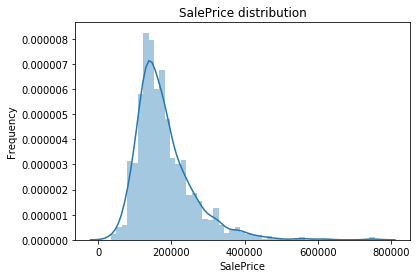

<Figure size 432x288 with 0 Axes>

In [10]:
sns.distplot(train['SalePrice']);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
plt.show()

Now a correlation matrix with all the variables:

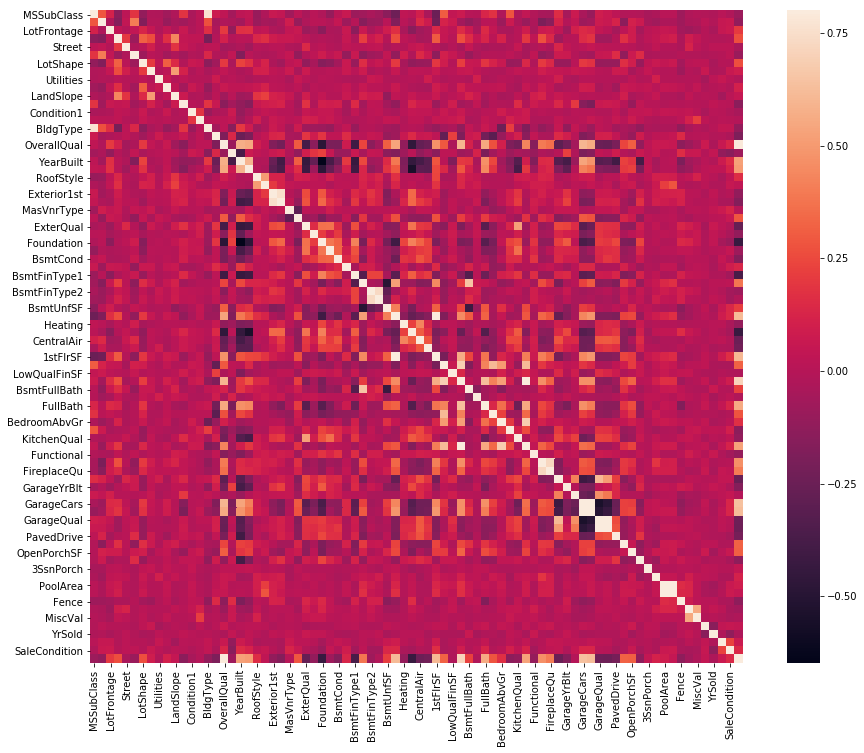

In [11]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.8, square=True)

Looking specifically at the SalePrice variable, we can see some very interesting features. The variable seems to be well correlated with some other variables such as `OverallQual`, `GrLivArea` and a few others. Looking at the `data_description.txt` file, we see that:

```
OverallQual: Rates the overall material and finish of the house
       10	Very Excellent
       [...]
       1	Very Poor
       
[...]

GrLivArea: Above grade (ground) living area square feet
```

This is a great start, but we must still look further into the data. Lets rank the other variables by their correlation with `SalePrice` and remove the least correlated by an arbitrary `0.5` correlation value:

In [12]:
most_corr = pd.DataFrame(corrmat['SalePrice'])
most_corr = most_corr[most_corr.SalePrice > 0.5]
most_corr

,SalePrice
OverallQual,0.790982
YearBuilt,0.522897
YearRemodAdd,0.507101
TotalBsmtSF,0.613581
1stFlrSF,0.605852
GrLivArea,0.708624
FullBath,0.560664
TotRmsAbvGrd,0.533723
GarageCars,0.640409
GarageArea,0.623431


So we have **10** most correlated features - all of them numerical! Lets plot them aggregating the price values in ranges:

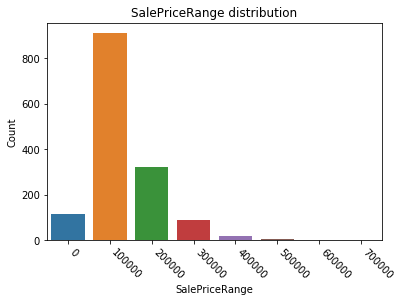

<Figure size 432x288 with 0 Axes>

In [13]:
new_set = pd.DataFrame(train)
bucket_size = 100000
for feature in train.axes[1]:
    if feature not in most_corr.axes[0]:
        new_set.drop(feature, axis = 1, inplace = True)
        
new_set.drop("SalePrice", axis = 1, inplace = True)
SalePriceRange = pd.DataFrame({"SalePriceRange":[str((int(x) // bucket_size) * bucket_size) for x in train["SalePrice"]]})
new_set = pd.concat([new_set, SalePriceRange], axis=1, sort=False)
#range_data = pd.DataFrame({'SalePriceRange': [str((int(x) // bucket_size) * bucket_size) for x in train["SalePrice"]]})
#new_set.join(range_data)
new_set["SalePriceRange"].describe()

sns.countplot(new_set["SalePriceRange"]);
plt.ylabel('Count')
plt.title('SalePriceRange distribution')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),rotation = (-45), fontsize = 10, va='top', ha='left')
fig = plt.figure()
plt.show()

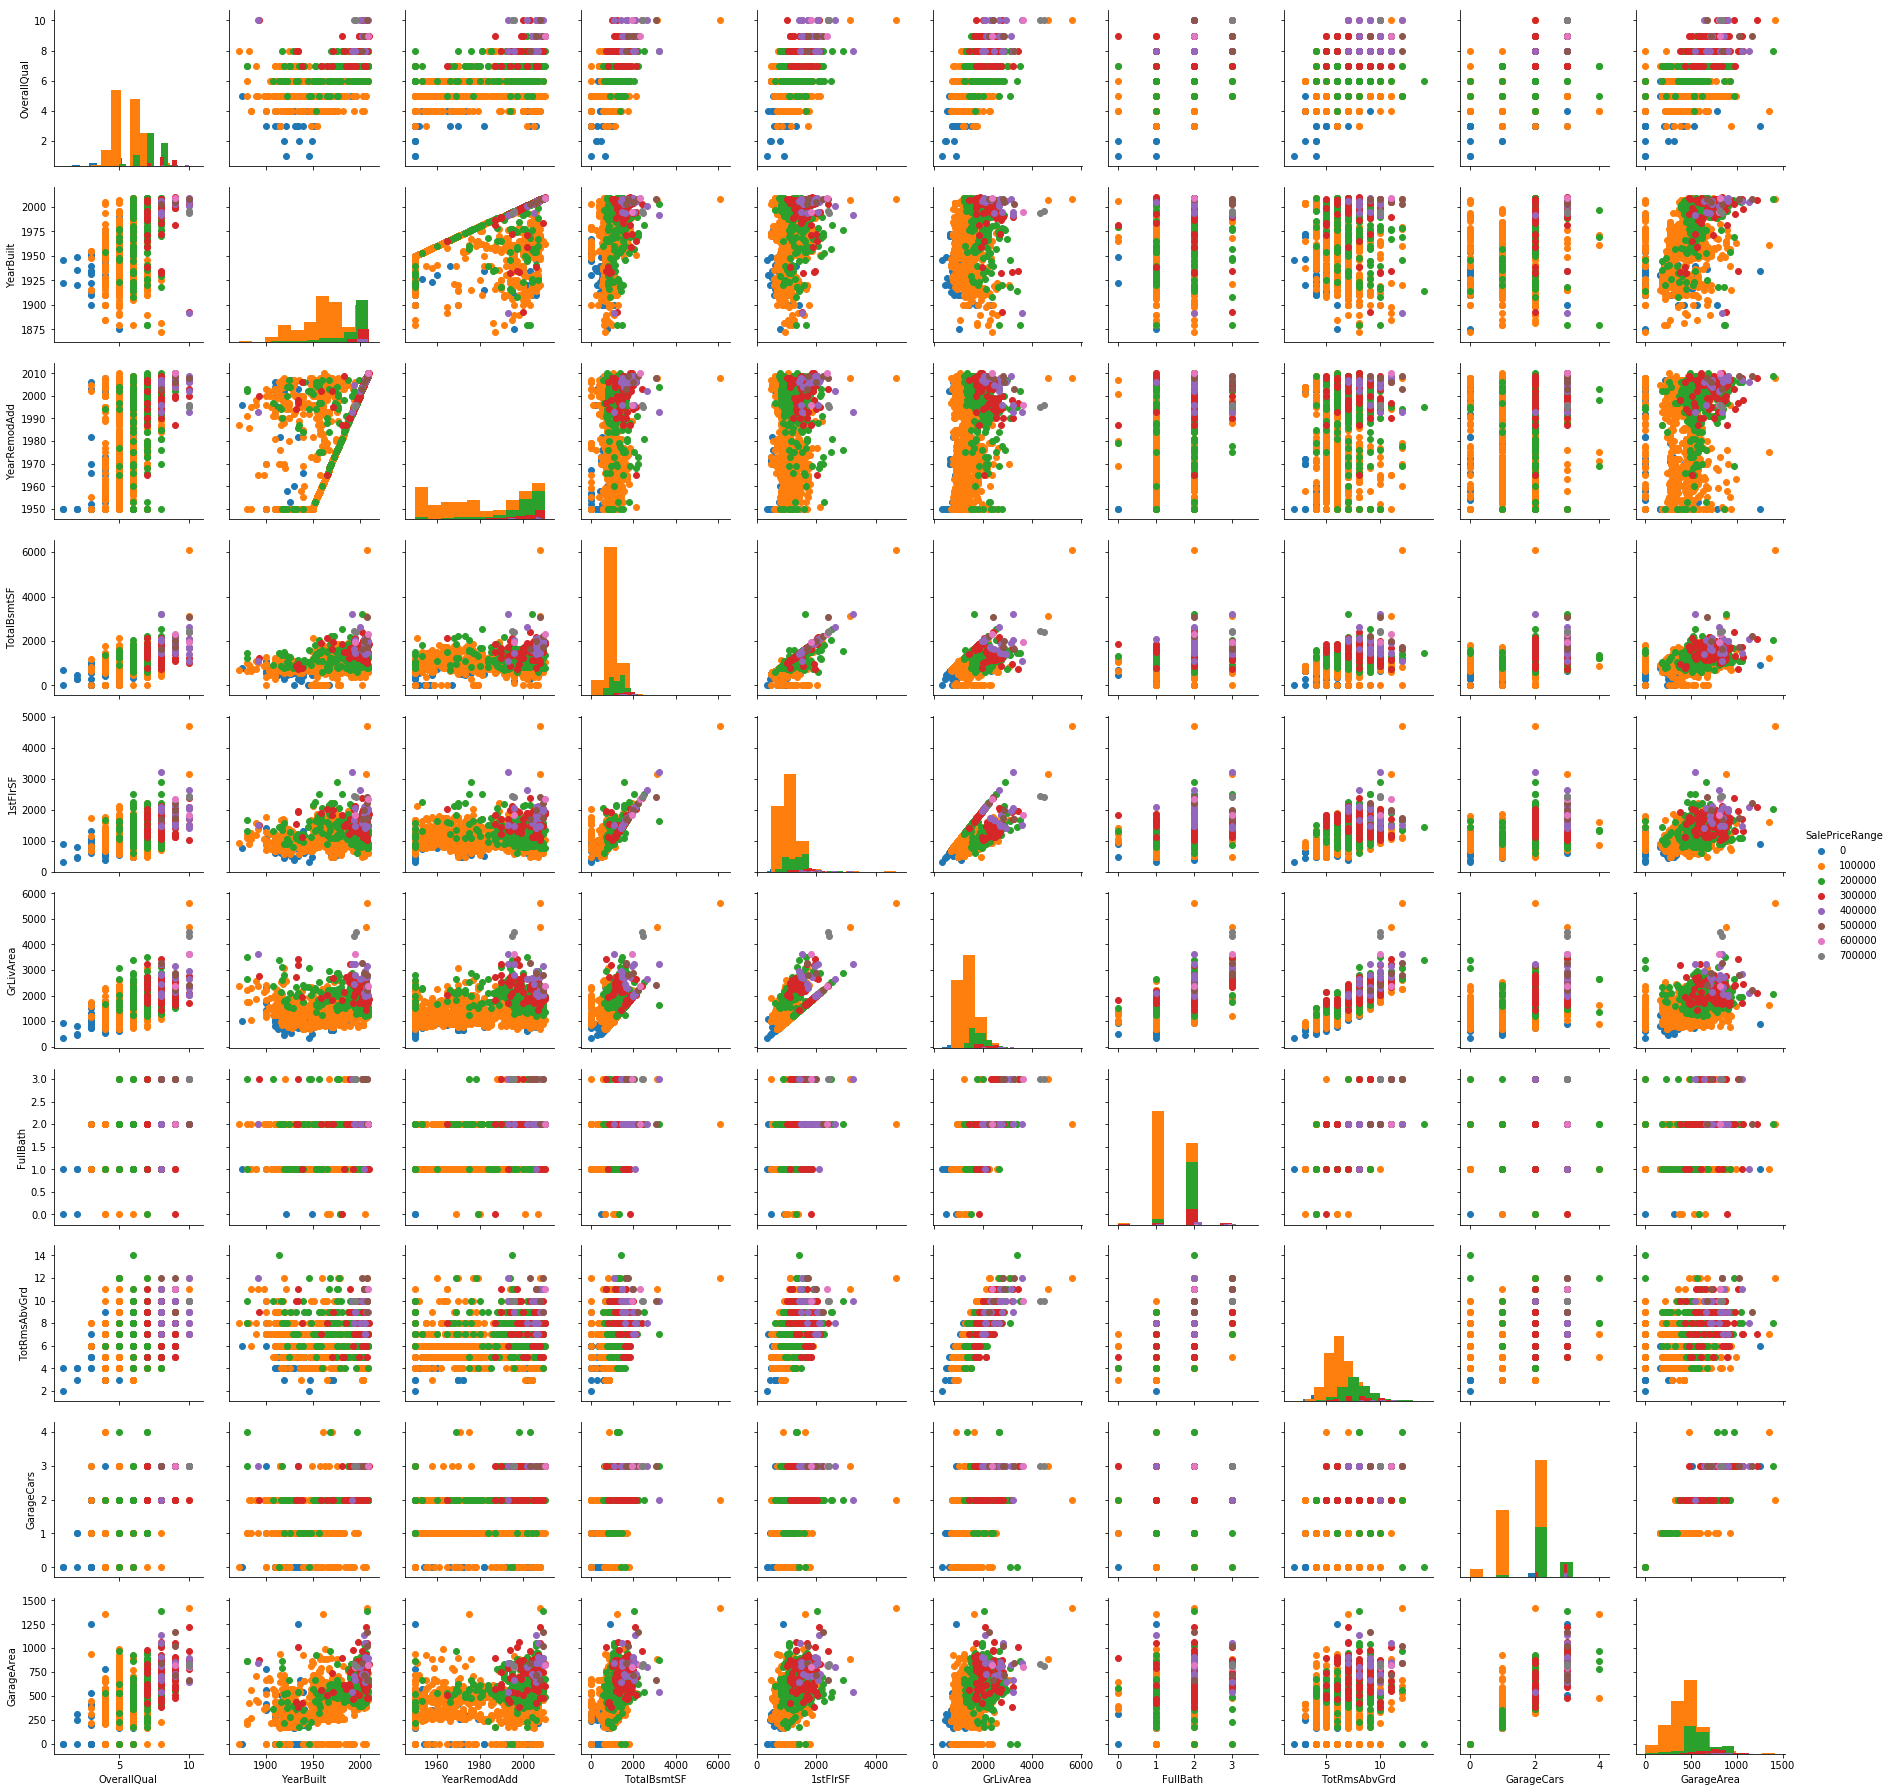

In [14]:
axes_vars = [x for x in new_set.axes[1] if x != "SalePriceRange"]
g = sns.PairGrid(new_set, vars=axes_vars, hue="SalePriceRange")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();


We can play around with the bucket size for this plot for a while, as I did, but even now we can see that there really are some combinations of features with waht seems to be a close to linear distinction of ranges. For example, at the plot [7,4]. Before we start modeling our problem, we must make some considerations about missing data and outliers. For this initial approach I will accept NA values as categoriacal data in all cases - which, for most features, is true, and will ignopre outliers. We may need to revise these decisions later.

For now, lets prepare the training/test data and a bunch of the models we will be comparing.

In [253]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Lars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
warnings.filterwarnings('ignore')

In [254]:
models = []
models.append(['LR', LinearRegression()])
models.append(['RD', Ridge()])
models.append(['LASSO', Lasso(alpha=0.015)])
models.append(['LARS', Lars(positive=True)])
models.append(['OMP', OrthogonalMatchingPursuit()])
models.append(['LG', LinearRegression()])
models.append(['EN', ElasticNet(max_iter=30)])
models.append(['KNN', KNeighborsRegressor()])
models.append(['CART', DecisionTreeRegressor()])
models.append(['SVR', SVR()])
models.append(['XGB', xgb.XGBRegressor()])
models.append(['GBR', GradientBoostingRegressor()])
#models.append(('PR', Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])))

# two groups of feature: those most correlated to our target and all of them
features_mc = train.loc[:, train.columns != 'SalePrice'].values
features_all = new_set.loc[:, new_set.columns != 'SalePriceRange'].values
targets = train.loc[:, train.columns == 'SalePrice'].values.flatten()

seed = 256
test_size = 0.20
num_folds = 10

Before going any further, let's standardize our data

In [255]:
fa_train, fa_validation, fc_train, fc_validation, t_train, t_validation = train_test_split(features_all, features_mc, targets, test_size=test_size, random_state=seed)
results = []
names = []
for i,features in enumerate([fa_train, fc_train]):
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        res = cross_val_score(model, features, t_train, cv=kfold, scoring='r2')
        good = np.asarray([x for x in res if x > 0])
        results.append(good)
        names.append(name + " " + ("all" if i%2==0 else "mc"))
        print("%s %s: %f (%f)" % (name, ("all" if i%2==0 else "mc"), good.mean(), good.std()))

LR all: 0.800871 (0.049881)
RD all: 0.800881 (0.049891)
LASSO all: 0.800871 (0.049881)
LARS all: 0.802361 (0.050822)
OMP all: 0.636624 (0.031110)
LG all: 0.800871 (0.049881)
EN all: 0.794487 (0.053859)
KNN all: 0.727732 (0.064965)
CART all: 0.723672 (0.062345)
SVR all: nan (nan)
XGB all: 0.843370 (0.062872)
GBR all: 0.847296 (0.066511)
LR mc: 0.844618 (0.074893)
RD mc: 0.845302 (0.074896)
LASSO mc: 0.844620 (0.074894)
LARS mc: 0.752314 (0.169400)
OMP mc: 0.810966 (0.062442)
LG mc: 0.844618 (0.074893)
EN mc: 0.843246 (0.068059)
KNN mc: 0.628088 (0.079593)
CART mc: 0.730097 (0.084324)
SVR mc: nan (nan)
XGB mc: 0.871892 (0.063297)
GBR mc: 0.879299 (0.066902)


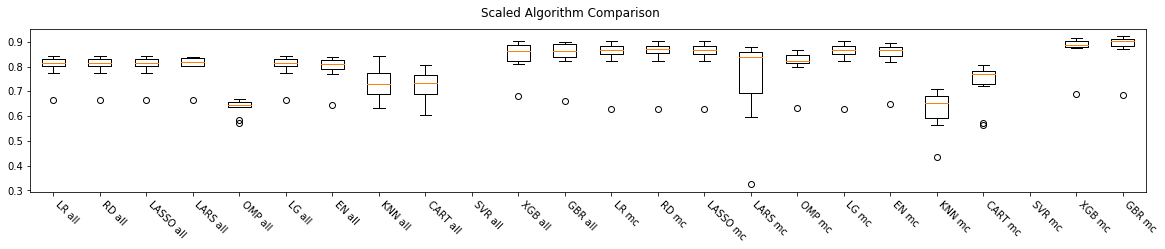

In [256]:
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names,rotation = (-45), fontsize = 10, va='top', ha='left')
pyplot.show()

We can see that using **only the most correlated features helps in most cases**. Let's try again standardizing the data.

In [257]:
pipeline = []
for model in models:
    pipeline.append([model[0], Pipeline([('Scaler', StandardScaler()),(model[0], model[1])])])

In [258]:
fa_train, fa_validation, fc_train, fc_validation, t_train, t_validation = train_test_split(features_all, features_mc, targets, test_size=test_size, random_state=seed)
results = []
names = []
for i,features in enumerate([fa_train, fc_train]):
    for name, model in pipeline:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        res = cross_val_score(model, features, t_train, cv=kfold, scoring='r2')
        good = np.asarray([x for x in res if x > 0])
        results.append(good)
        names.append(name + " " + ("all" if i%2==0 else "mc"))
        print("%s %s: %f (%f)" % (name, ("all" if i%2==0 else "mc"), good.mean(), good.std()))

LR all: 0.800871 (0.049881)
RD all: 0.800884 (0.049862)
LASSO all: 0.800871 (0.049881)
LARS all: 0.802361 (0.050822)
OMP all: 0.636624 (0.031110)
LG all: 0.800871 (0.049881)
EN all: 0.779017 (0.047639)
KNN all: 0.822200 (0.054591)
CART all: 0.736995 (0.075497)
SVR all: nan (nan)
XGB all: 0.843356 (0.062842)
GBR all: 0.848284 (0.065559)
LR mc: 0.842215 (0.078542)
RD mc: 0.844762 (0.074796)
LASSO mc: 0.844619 (0.074893)
LARS mc: 0.752314 (0.169400)
OMP mc: 0.810966 (0.062442)
LG mc: 0.842215 (0.078542)
EN mc: 0.840101 (0.059713)
KNN mc: 0.767164 (0.056174)
CART mc: 0.748029 (0.080997)
SVR mc: nan (nan)
XGB mc: 0.871886 (0.063295)
GBR mc: 0.880517 (0.067013)


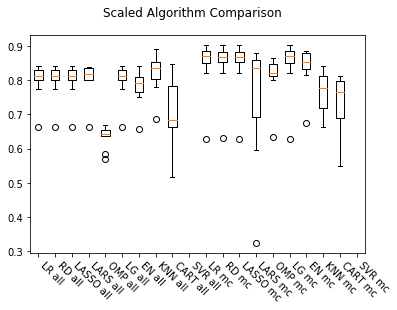

In [244]:
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names,rotation = (-45), fontsize = 10, va='top', ha='left')
pyplot.show()